# Binary Classification on Health Data
Bayes classifier - GMM, Gaussian, Naive Bayes

In [1]:
import pandas as pd
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./health_data.csv').values
print(type(data), data.shape)
print("class distribution",np.bincount(data[:,-1]))

<class 'numpy.ndarray'> (700, 4)
class distribution [400 300]


In [3]:
np.random.shuffle(data)

train_data=data[0:490,:]
TEST_data=data[490:700,:]

Cross_Validation_data=np.array_split(train_data,5)
print(len(Cross_Validation_data))

X_TEST,y_TEST = TEST_data[:,:-1],TEST_data[:,-1:]
print(X_TEST.shape, y_TEST.shape)

5
(210, 3) (210, 1)


In [4]:
print(train_data.shape, Cross_Validation_data[0].shape)
print('train data size = 398\nval data size = 98\nTEST data size = 210')

(490, 4) (98, 4)
train data size = 398
val data size = 98
TEST data size = 210


## Classification Performance Metrics

In [5]:
#assuming y_pred, y_true shape is (n,)
#assuming class 1 is positive, and other is negative
#assuming multi-class such that ypred,ytrue has values in 0,1,2,..,label-1

def classification_performance_metrics(y_pred, y_true):
    n=y_true.shape
    
    tp_indices = y_pred==y_true
    tp = y_true[tp_indices]
    
    true_y_per_class = np.bincount(y_true)
    labels = true_y_per_class.shape[0]
    
    tp_per_class = np.zeros((labels,))
    tp_per_class[:np.bincount(tp).shape[0]] = np.bincount(tp)
    predicted_y_per_class = np.zeros((labels,))
    predicted_y_per_class[:np.bincount(y_pred).shape[0]] = np.bincount(y_pred)
    
    
    acc = 100 * tp_per_class.sum()/n
    
    #precision, recall, F1 for each class
    for i in range(tp_per_class.shape[0]):
        TP = tp_per_class[i]
        TN = tp_per_class.sum() - TP
        FP = predicted_y_per_class[i] - TP
        FN = true_y_per_class[i] - TP
        
        precision = TP/(TP+FP) if TP+FP!=0 else 0
        recall = TP/(TP+FN) if TP+FN!=0 else 0
        F1 = 2*TP/(2*TP+FP+FN) if TP+FP+FN!=0 else 0
        FPR = FP/(FP+TN) if FP+TN!=0 else 0

#         print("class{}".format(i),precision,recall,F1)
    
    performance={}
    performance['acc']=acc
    performance['precision']=precision
    performance['TPR']=recall
    performance['recall']=recall
    performance['F1']=F1
    performance['FPR']=FPR
    return performance

# Bayes Classifier using Parametric Estimation of Class conditional densities

# 1. Multivariate Gaussian

In [19]:
def multi_variate_gaussian(x, mu, sigma):
    y = ((x-mu).T.dot(np.linalg.inv(sigma))).dot(x-mu)
    y = -y/2
    y = np.exp(y)
    constant = pow(2*3.14,x.shape[0])
    constant = constant*np.linalg.det(sigma)
    constant = pow(constant, 1/2)
    y = y/constant
    return y

def bayes_classifier(X, threshold, p_0, p_1, MLE):
    #posteriors (not normalised)
    y_pred = np.zeros((X.shape[0],),dtype=np.uint8)
    for i in range(X.shape[0]):
        x=X[i]
        Q_0 = p_0*multi_variate_gaussian(x, MLE['mu_0'], MLE['sigma_0'])
        Q_1 = p_1*multi_variate_gaussian(x, MLE['mu_1'], MLE['sigma_1']) 
        
        if Q_0<threshold*Q_1:
            y_pred[i]=1
            
    return y_pred

def bayes_classifier_MVG(train, test, threshold): #train,test = X|Y
    #separate the class 0 and 1 in train set to find MLE for class conditional densities
    train_class_0 = train[train[:,-1]==0]
    train_class_1 = train[train[:,-1]==1]
#     print("classes separated in train set", train_class_0.shape, train_class_1.shape)
    
    #priors
    p_0 = train_class_0.shape[0]/train.shape[0]
    p_1 = train_class_1.shape[0]/train.shape[0]
#     print("priors", p_0, p_1)
    
    #compute MLE for mu and sigma
    MLE={}
    X=train_class_0[:,:-1]
    MLE['mu_0']=X.mean(axis=0)
    MLE['sigma_0']=np.cov(X.T)#(X - MLE['mu_0']).T.dot(X - MLE['mu_0'])/(X.shape[0])
    X=train_class_1[:,:-1]
    MLE['mu_1']=X.mean(axis=0)
    MLE['sigma_1']=np.cov(X.T)#(X - MLE['mu_1']).T.dot(X - MLE['mu_1'])/(X.shape[0])
#     print("Maximum Likelihood Estimates for class conditional densities")
#     print(MLE)

    y_pred_train = bayes_classifier(train[:,:-1], threshold, p_0, p_1, MLE)
    y_pred_test = bayes_classifier(test[:,:-1], threshold, p_0, p_1, MLE)
    
    return y_pred_train, y_pred_test, MLE

In [20]:
#cross validate 
def cross_validate(Cross_Validation_data, threshold):
    train_performance_CV, test_performance_CV = [],[]
    
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        train = remaining_data_for_training
        test = validation_data
        y_pred_train, y_pred_test, _ = bayes_classifier_MVG(train, test, threshold)
        
        train_performance = classification_performance_metrics(y_pred_train, train[:,-1])
        test_performance = classification_performance_metrics(y_pred_test, test[:,-1])

        train_performance_CV.append(train_performance)
        test_performance_CV.append(test_performance)

    train_performance={}
    train_performance['acc']=train_performance['precision']=train_performance['TPR']=train_performance['recall']=train_performance['F1']=train_performance['FPR']=0
    test_performance={}
    test_performance['acc']=test_performance['precision']=test_performance['TPR']=test_performance['recall']=test_performance['F1']=test_performance['FPR']=0

    n_cv = len(train_performance_CV)
    for i in range(n_cv): #cross validation of 5
        for key in train_performance:
            train_performance[key]+=train_performance_CV[i][key]
            test_performance[key]+=test_performance_CV[i][key]
    for key in train_performance:
        train_performance[key]/=n_cv
        test_performance[key]/=n_cv

    return train_performance, test_performance

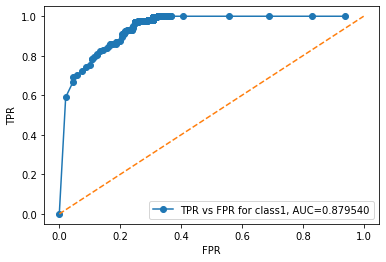

In [13]:
#plot the roc curve | using cross validation
TPR_ROC, FPR_ROC = [], []
thresholds=list(np.arange(0,25,0.1))+list(np.arange(25,50,2.))+[100,1000,10000,100000,1000000]
for threshold in thresholds:
    print('threshold %f'%threshold,end='\r')
    _1, _2 = cross_validate(Cross_Validation_data, threshold)
    TPR_ROC.append(_2['TPR'])
    FPR_ROC.append(_2['FPR'])

plt.plot(FPR_ROC, TPR_ROC,label='TPR vs FPR for class1, AUC=%f'%np.trapz(TPR_ROC,FPR_ROC),marker='o')
plt.plot(np.arange(0,1.1,.1),np.arange(0,1.1,.1),linestyle='dashed')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig('ROC_MVG_Health_data.png',dpi=300)
plt.show()

In [22]:
TPR_Exp1 = TPR_ROC
FPR_Exp1 = FPR_ROC

In [23]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
train_perf, val_perf = cross_validate(Cross_Validation_data, threshold=1)
print("train performance", train_perf)
print('validation performance', val_perf),print()

y_pred_train, y_pred_TEST, _ = bayes_classifier_MVG(train_data, TEST_data, threshold=1)
train_performance = classification_performance_metrics(y_pred_train, train_data[:,-1])
TEST_performance = classification_performance_metrics(y_pred_TEST, TEST_data[:,-1])
print("train performance", train_performance)
print('TEST performance', TEST_performance)

train performance {'acc': array([85.35714286]), 'precision': 0.8207885268047199, 'TPR': 0.8465114769626266, 'recall': 0.8465114769626266, 'F1': 0.8333690552701032, 'FPR': 0.14154726226868714}
validation performance {'acc': array([84.69387755]), 'precision': 0.8181089743589745, 'TPR': 0.8347784519213091, 'recall': 0.8347784519213091, 'F1': 0.8238900185153973, 'FPR': 0.15303427381881712}

train performance {'acc': array([85.10204082]), 'precision': 0.8232558139534883, 'TPR': 0.8349056603773585, 'recall': 0.8349056603773585, 'F1': 0.8290398126463701, 'FPR': 0.1366906474820144}
TEST performance {'acc': array([87.14285714]), 'precision': 0.8961038961038961, 'TPR': 0.7840909090909091, 'recall': 0.7840909090909091, 'F1': 0.8363636363636363, 'FPR': 0.06557377049180328}


# 2. Multivariate Gaussian with statistical independence btw features - Naive Bayes

In [27]:
def uni_variate_gaussian(x, mu, sigma):
    y = -(x-mu)**2
    y = y/((sigma)**2)
    y = y/2
    y = np.exp(y)
    constant = pow(2*3.14,1/2)
    constant = constant*sigma
    y = y/constant
    return y

def bayes_classifier(X, threshold, p_0, p_1, MLE):
    #posteriors (not normalised)
    y_pred = np.zeros((X.shape[0],),dtype=np.uint8)
    for i in range(X.shape[0]):
        x=X[i]
        Q_0 = p_0
        Q_1 = p_1
        for j in range(x.shape[0]):
            Q_0 = Q_0 * uni_variate_gaussian(x[j], MLE['mu_0'][j], MLE['sigma_0_{}'.format(j)])
            Q_1 = Q_1 * uni_variate_gaussian(x[j], MLE['mu_1'][j], MLE['sigma_1_{}'.format(j)]) 
        if Q_0<threshold*Q_1:
            y_pred[i]=1
            
    return y_pred

def bayes_classifier_MuVG(train, test, threshold): #train,test = X|Y
    #separate the class 0 and 1 in train set to find MLE for class conditional densities
    train_class_0 = train[train[:,-1]==0]
    train_class_1 = train[train[:,-1]==1]
#     print("classes separated in train set", train_class_0.shape, train_class_1.shape)
    
    #priors
    p_0 = train_class_0.shape[0]/train.shape[0]
    p_1 = train_class_1.shape[0]/train.shape[0]
#     print("priors", p_0, p_1)
    
    #compute MLE for mu and sigma
    MLE={}
    X=train_class_0[:,:-1]
    MLE['mu_0']=X.mean(axis=0)
    for j in range(X.shape[1]):
        MLE['sigma_0_{}'.format(j)]=X[:,j].std(axis=0)
    X=train_class_1[:,:-1]
    MLE['mu_1']=X.mean(axis=0)
    for j in range(X.shape[1]):
        MLE['sigma_1_{}'.format(j)]=X[:,j].std(axis=0)
#     print("Maximum Likelihood Estimates for class conditional densities")
#     print(MLE)
    
    #use bayes classifier
    y_pred_train = bayes_classifier(train[:,:-1], threshold, p_0, p_1, MLE)
    y_pred_test = bayes_classifier(test[:,:-1], threshold, p_0, p_1, MLE)
    
    return y_pred_train, y_pred_test, MLE

In [28]:
#cross validate 
def cross_validate(Cross_Validation_data, threshold):
    train_performance_CV, test_performance_CV = [],[]
    
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        train = remaining_data_for_training
        test = validation_data
        y_pred_train, y_pred_test, _ = bayes_classifier_MuVG(train, test, threshold)
        
        train_performance = classification_performance_metrics(y_pred_train, train[:,-1])
        test_performance = classification_performance_metrics(y_pred_test, test[:,-1])

        train_performance_CV.append(train_performance)
        test_performance_CV.append(test_performance)

    train_performance={}
    train_performance['acc']=train_performance['precision']=train_performance['TPR']=train_performance['recall']=train_performance['F1']=train_performance['FPR']=0
    test_performance={}
    test_performance['acc']=test_performance['precision']=test_performance['TPR']=test_performance['recall']=test_performance['F1']=test_performance['FPR']=0

    n_cv = len(train_performance_CV)
    for i in range(n_cv): #cross validation of 5
        for key in train_performance:
            train_performance[key]+=train_performance_CV[i][key]
            test_performance[key]+=test_performance_CV[i][key]
    for key in train_performance:
        train_performance[key]/=n_cv
        test_performance[key]/=n_cv

    return train_performance, test_performance

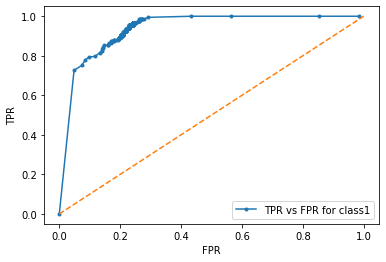

In [29]:
#plot the roc curve | using cross validation
TPR_ROC, FPR_ROC = [], []
thresholds=list(np.arange(0,25,0.1))+list(np.arange(25,50,2.))+[100,1000,10000,100000,1000000]
for threshold in thresholds:
    print('threshold %f'%threshold,end='\r')
    _1, _2 = cross_validate(Cross_Validation_data, threshold)
    TPR_ROC.append(_2['TPR'])
    FPR_ROC.append(_2['FPR'])

plt.plot(FPR_ROC, TPR_ROC,label='TPR vs FPR for class1',marker='.')
plt.plot(np.arange(0,1.1,.1),np.arange(0,1.1,.1),linestyle='dashed')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig('ROC_MuVG_Health_data.png',dpi=300)
plt.show()

In [31]:
TPR_Exp2 = TPR_ROC
FPR_Exp2 = FPR_ROC

In [30]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
train_perf, val_perf = cross_validate(Cross_Validation_data, threshold=1)
print("train performance", train_perf)
print('validation performance', val_perf),print()

y_pred_train, y_pred_TEST, _ = bayes_classifier_MuVG(train_data, TEST_data, threshold=1)
train_performance = classification_performance_metrics(y_pred_train, train_data[:,-1])
TEST_performance = classification_performance_metrics(y_pred_TEST, TEST_data[:,-1])
print("train performance", train_performance)
print('TEST performance', TEST_performance)

train performance {'acc': array([85.30612245]), 'precision': 0.8173157267521187, 'TPR': 0.8500448849187174, 'recall': 0.8500448849187174, 'F1': 0.8333517381300686, 'FPR': 0.14495089933903788}
validation performance {'acc': array([85.51020408]), 'precision': 0.8267244780442194, 'TPR': 0.8429784886927744, 'recall': 0.8429784886927744, 'F1': 0.8318746102378943, 'FPR': 0.1441721497342106}

train performance {'acc': array([85.30612245]), 'precision': 0.8211009174311926, 'TPR': 0.8443396226415094, 'recall': 0.8443396226415094, 'F1': 0.8325581395348837, 'FPR': 0.14028776978417265}
TEST performance {'acc': array([86.66666667]), 'precision': 0.9054054054054054, 'TPR': 0.7613636363636364, 'recall': 0.7613636363636364, 'F1': 0.8271604938271605, 'FPR': 0.05737704918032787}


# 3. Gaussian mixture model - class conditional density

### Visualizing 3D data to estimate number of modes

In [33]:
X_train_class_0 = train_data[train_data[:,-1]==0][:,:-1]
X_train_class_1 = train_data[train_data[:,-1]==1][:,:-1]
print(X_train_class_0.shape, X_train_class_1.shape)

(278, 3) (212, 3)


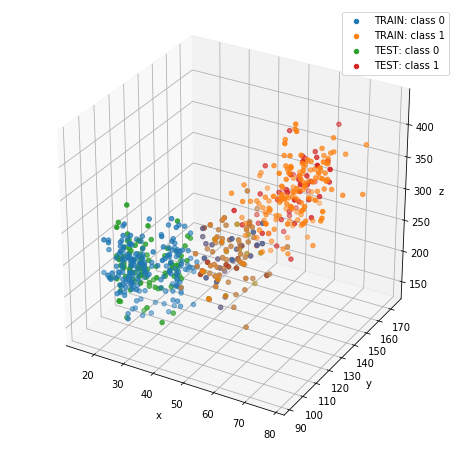

In [15]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_class_0[:,0], X_train_class_0[:,1], X_train_class_0[:,2], label='TRAIN: class 0')
ax.scatter3D(X_train_class_1[:,0], X_train_class_1[:,1], X_train_class_1[:,2], label='TRAIN: class 1')
X_test_class_0 = test[test[:,-1]==0][:,:-1]
X_test_class_1 = test[test[:,-1]==1][:,:-1]
ax.scatter3D(X_test_class_0[:,0], X_test_class_0[:,1], X_test_class_0[:,2], label='TEST: class 0')
ax.scatter3D(X_test_class_1[:,0], X_test_class_1[:,1], X_test_class_1[:,2], label='TEST: class 1')
plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.savefig('health dataset.png', dpi = 300)
plt.show()

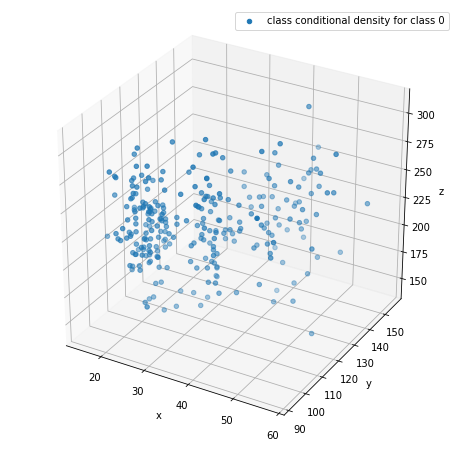

In [16]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_class_0[:,0], X_train_class_0[:,1], X_train_class_0[:,2], label='class conditional density for class 0')
plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()
#plt.savefig('3d_wireframe.png', dpi = 300)

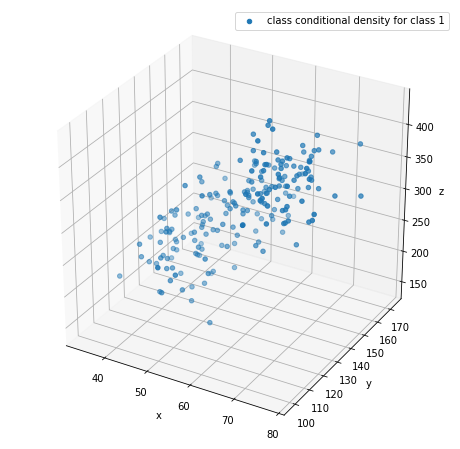

In [17]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_class_1[:,0], X_train_class_1[:,1], X_train_class_1[:,2], label='class conditional density for class 1')
plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()
#plt.savefig('3d_wireframe.png', dpi = 300)

In [ ]:
# Cite: https://github.com/Sharut/gmm-python/blob/master/gmm.py
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def random_parameters(data, K):
    """ init the means, covariances and mixing coefs"""
    cols = (data.shape)[1]
 
    mu = np.zeros((K, cols))
    for k in range(K):
        idx = int(np.floor(rd.random()*len(data)))
        for col in range(cols):
            mu[k][col] += data[idx][col]
 
    sigma = []
    for k in range(K):
        sigma.append(np.cov(data.T))
 
    pi = np.ones(K)*1.0/K
 
    return mu, sigma, pi

def e_step(data, K, mu, sigma, pi):
    idvs = (data.shape)[0]
    cols = (data.shape)[1]
 
    resp = np.zeros((idvs, K))
 
    for i in range(idvs):
        for k in range(K):
            resp[i][k] = pi[k]*gaussian(data[i], mu[k], sigma[k])/likelihood(data[i], K, mu, sigma, pi)

    return resp

def log_likelihood(data, K, mu, sigma, pi):
    """ marginal over X """
    log_likelihood = 0.0
    for n in range (len(data)):
        log_likelihood += np.log(likelihood(data[n], K, mu, sigma, pi))
    return log_likelihood 

 
def likelihood(x, K, mu, sigma, pi):
    rs = 0.0
    for k in range(K):
        rs += pi[k]*gaussian(x, mu[k], sigma[k])
    return rs


def m_step(data, K, resp):
    """ find the parameters that maximize the log-likelihood given the current resp."""
    idvs = (data.shape)[0]
    cols = (data.shape)[1]
    
    mu = np.zeros((K, cols))
    sigma = np.zeros((K, cols, cols))
    pi = np.zeros(K)

    marg_resp = np.zeros(K)
    for k in range(K):
        for i in range(idvs):
            marg_resp[k] += resp[i][k]
            mu[k] += (resp[i][k])*data[i]
        mu[k] /= marg_resp[k]

        for i in range(idvs):
            #x_i = (np.zeros((1,cols))+data[k])
            x_mu = np.zeros((1,cols))+data[i]-mu[k]
            sigma[k] += (resp[i][k]/marg_resp[k])*x_mu*x_mu.T

        pi[k] = marg_resp[k]/idvs        
        
    return mu, sigma, pi


def gaussian(x, mu, sigma):
    """ compute the pdf of the multi-var gaussian """
    idvs = len(x)
    norm_factor = (2*np.pi)**idvs

    norm_factor *= np.linalg.det(sigma)
    norm_factor = 1.0/np.sqrt(norm_factor)

    x_mu = np.matrix(x-mu)

    rs = norm_factor*np.exp(-0.5*x_mu*np.linalg.inv(sigma)*x_mu.T)
    return rs


def EM(data, K, threshold):
    converged = False
    mu, sigma, pi = random_parameters(data, K)
    
    l=[]
    current_log_likelihood = log_likelihood(data, K, mu, sigma, pi)
    max_iter = 30
    for it in range(max_iter):
        resp = e_step(data, K, mu, sigma, pi)
        mu, sigma, pi = m_step(data, K, resp)
        l.append(current_log_likelihood[0,0])
        new_log_likelihood = log_likelihood(data, K, mu, sigma, pi)
#         if (abs(new_log_likelihood-current_log_likelihood) < threshold):
#             converged = True
#             break

        current_log_likelihood = new_log_likelihood
    
    l.append(current_log_likelihood[0,0])
    
    return l, mu, sigma

In [36]:
def predict(X, mu, sigma, n_components):
    probabs = []
    for n in range(len(X)):
        probabs.append([gaussian(X[n], mu[k], sigma[k]) for k in range(n_components)])
    final_probs = []
    for probab in probabs:
        final_probs.append(max(probab))
    return final_probs

In [37]:
def bayes_classifier(X, threshold, p_0, p_1, mu_0, sigma_0, mu_1, sigma_1, n_components):
    #posteriors (not normalised)
    y_pred = np.zeros((X.shape[0],),dtype=np.uint8)
    
    f_0 = predict(X, mu_0, sigma_0, n_components)
    Q_0 = [p_0*f[0,0] for f in f_0]
    
    f_1 = predict(X, mu_1, sigma_1, n_components)
    Q_1 = [p_1*f[0,0] for f in f_1]
    
    Q_0=np.array(Q_0)
    Q_1=np.array(Q_1)
    y_pred[ Q_0<threshold*Q_1  ] = 1
    
    return y_pred

In [38]:
def bayes_classifier_GMM(train, test, n_components, threshold): #train,test = X|Y
    #separate the class 0 and 1 in train set to find MLE for class conditional densities
    train_class_0 = train[train[:,-1]==0]
    train_class_1 = train[train[:,-1]==1]
#     print("classes separated in train set", train_class_0.shape, train_class_1.shape)
    
    #priors
    p_0 = train_class_0.shape[0]/train.shape[0]
    p_1 = train_class_1.shape[0]/train.shape[0]
#     print("priors", p_0, p_1)
    
    #fit GMM using MLE for train set
    X=train_class_0[:,:-1]
    log_likelihoods_0, mu_0, sigma_0 = EM(X,n_components,0.001)
    
    X=train_class_1[:,:-1]
    log_likelihoods_1, mu_1, sigma_1 = EM(X,n_components,0.001)
    
    GMM_parameters = {}
    GMM_parameters['log_likelihoods_0']=log_likelihoods_0
    GMM_parameters['log_likelihoods_1']=log_likelihoods_1
    GMM_parameters['mu_0']=mu_0
    GMM_parameters['mu_1']=mu_1
    GMM_parameters['sigma_0']=sigma_0
    GMM_parameters['sigma_1']=sigma_1

    #use bayes classifier
    y_pred_train = bayes_classifier(train[:,:-1], threshold, p_0, p_1, mu_0, sigma_0, mu_1, sigma_1, n_components)
    y_pred_test = bayes_classifier(test[:,:-1], threshold, p_0, p_1, mu_0, sigma_0, mu_1, sigma_1, n_components)
    
    return y_pred_train, y_pred_test, GMM_parameters

In [39]:
#cross validate 
def cross_validate(Cross_Validation_data, n_components, threshold):
    train_performance_CV, test_performance_CV = [],[]
    
    for i,validation_data in enumerate(Cross_Validation_data):
#         print('cross validating on part %u'%i,end='\r')
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        train = remaining_data_for_training
        test = validation_data
        y_pred_train, y_pred_test, _ = bayes_classifier_GMM(train, test, n_components, threshold)
        
        train_performance = classification_performance_metrics(y_pred_train, train[:,-1])
        test_performance = classification_performance_metrics(y_pred_test, test[:,-1])

        train_performance_CV.append(train_performance)
        test_performance_CV.append(test_performance)
        
        break #just take 1 for now, taking too much time

    train_performance={}
    train_performance['acc']=train_performance['precision']=train_performance['TPR']=train_performance['recall']=train_performance['F1']=train_performance['FPR']=0
    test_performance={}
    test_performance['acc']=test_performance['precision']=test_performance['TPR']=test_performance['recall']=test_performance['F1']=test_performance['FPR']=0

    n_cv = len(train_performance_CV)
    for i in range(n_cv): #cross validation of 5
        for key in train_performance:
            train_performance[key]+=train_performance_CV[i][key]
            test_performance[key]+=test_performance_CV[i][key]
    for key in train_performance:
        train_performance[key]/=n_cv
        test_performance[key]/=n_cv

    return train_performance, test_performance

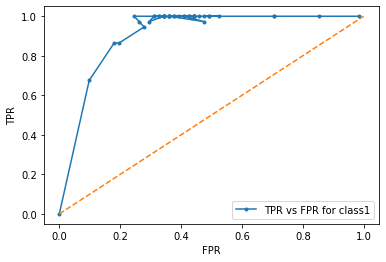

In [44]:
#plot the roc curve | using cross validation
TPR_ROC, FPR_ROC = [], []
thresholds=list(np.arange(0,25,1))+list(np.arange(25,50,2.))+[100,1000,10000,100000,1000000]
for threshold in thresholds:
    print('threshold %f'%threshold,end='\r')
    _1, _2 = cross_validate(Cross_Validation_data, 2, threshold)
    TPR_ROC.append(_2['TPR'])
    FPR_ROC.append(_2['FPR'])

plt.plot(FPR_ROC, TPR_ROC,label='TPR vs FPR for class1',marker='.')
plt.plot(np.arange(0,1.1,.1),np.arange(0,1.1,.1),linestyle='dashed')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig('ROC_GMM_Health_data.png',dpi=300)
plt.show()

In [41]:
TPR_Exp3 = TPR_ROC
FPR_Exp3 = FPR_ROC

In [26]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
train_perf, val_perf = cross_validate(Cross_Validation_data, 2, 1)
print("train performance", train_perf)
print('validation performance', val_perf)

train performance {'acc': array([83.92857143]), 'precision': 0.7772020725388601, 'TPR': 0.8823529411764706, 'recall': 0.8823529411764706, 'F1': 0.8264462809917356, 'FPR': 0.19369369369369369}
validation performance {'acc': array([84.69387755]), 'precision': 0.8076923076923077, 'TPR': 0.8936170212765957, 'recall': 0.8936170212765957, 'F1': 0.8484848484848485, 'FPR': 0.19607843137254902}


In [25]:
y_pred_train, y_pred_TEST, GMM_parameters = bayes_classifier_GMM(train_data, TEST_data, 2, 1)
train_performance = classification_performance_metrics(y_pred_train, train_data[:,-1])
TEST_performance = classification_performance_metrics(y_pred_TEST, TEST_data[:,-1])
print("train performance", train_performance)
print('TEST performance', TEST_performance)

train performance {'acc': array([85.30612245]), 'precision': 0.9341317365269461, 'TPR': 0.7188940092165899, 'recall': 0.7188940092165899, 'F1': 0.8125, 'FPR': 0.040293040293040296}
TEST performance {'acc': array([86.19047619]), 'precision': 0.95, 'TPR': 0.6867469879518072, 'recall': 0.6867469879518072, 'F1': 0.7972027972027972, 'FPR': 0.023622047244094488}


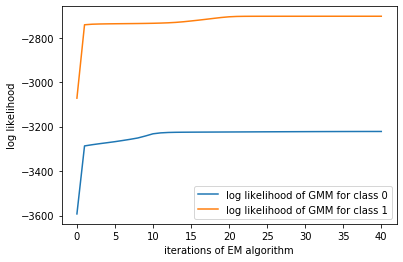

In [27]:
plt.xlabel('iterations of EM algorithm')
plt.ylabel('log likelihood')
plt.plot(GMM_parameters['log_likelihoods_0'],label='log likelihood of GMM for class 0')
plt.plot(GMM_parameters['log_likelihoods_1'],label='log likelihood of GMM for class 1')
plt.legend()
plt.show()

In [29]:
# np.save('GMM_1.npy',GMM_parameters)
#GMM_1=np.load('GMM_1.npy',allow_pickle=True).item()

In [49]:
Q1_MLE_ROC = np.load('Q1_MLE_ROC.npy',allow_pickle=True)
len(Q1_MLE_ROC[0])

268

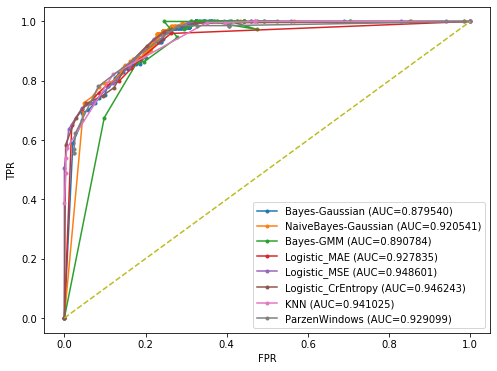

In [5]:
import numpy as np
import matplotlib.pyplot as plt
Q1_MLE_ROC = np.load('Q1_MLE_ROC.npy',allow_pickle=True)
Q1_KNNParzen_ROC = np.load('Q1_KNNParzen_ROC.npy',allow_pickle=True)
logistic_3lossFn_roc = np.load('logistic_3lossFn_roc.npy')

plt.figure(figsize=(8.,6.))
plt.plot(Q1_MLE_ROC[0], Q1_MLE_ROC[3],label='Bayes-Gaussian (AUC=%f)'%np.trapz(Q1_MLE_ROC[3],Q1_MLE_ROC[0]),marker='.')
plt.plot(Q1_MLE_ROC[1], Q1_MLE_ROC[4],label='NaiveBayes-Gaussian (AUC=%f)'%np.trapz(Q1_MLE_ROC[4],Q1_MLE_ROC[1]),marker='.')
plt.plot(Q1_MLE_ROC[2], Q1_MLE_ROC[5],label='Bayes-GMM (AUC=%f)'%np.trapz(Q1_MLE_ROC[5],Q1_MLE_ROC[2]),marker='.')

plt.plot(logistic_3lossFn_roc[0,0], logistic_3lossFn_roc[1,0],label='Logistic_MAE (AUC=%f)'%np.trapz(logistic_3lossFn_roc[1,0],logistic_3lossFn_roc[0,0]),marker='.')
plt.plot(logistic_3lossFn_roc[0,1], logistic_3lossFn_roc[1,1],label='Logistic_MSE (AUC=%f)'%np.trapz(logistic_3lossFn_roc[1,1],logistic_3lossFn_roc[0,1]),marker='.')
plt.plot(logistic_3lossFn_roc[0,2], logistic_3lossFn_roc[1,2],label='Logistic_CrEntropy (AUC=%f)'%np.trapz(logistic_3lossFn_roc[1,2],logistic_3lossFn_roc[0,2]),marker='.')

plt.plot(Q1_KNNParzen_ROC[0], Q1_KNNParzen_ROC[2],label='KNN (AUC=%f)'%np.trapz(Q1_KNNParzen_ROC[2],Q1_KNNParzen_ROC[0]),marker='.')
plt.plot(Q1_KNNParzen_ROC[1], Q1_KNNParzen_ROC[3],label='ParzenWindows (AUC=%f)'%np.trapz(Q1_KNNParzen_ROC[3],Q1_KNNParzen_ROC[1]),marker='.')


plt.plot(np.arange(0,1.1,.1),np.arange(0,1.1,.1),linestyle='dashed')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig('Q1_ROCs.png',dpi=300)
plt.show()

In [45]:
d=np.array([FPR_Exp1,FPR_Exp2,FPR_Exp3,TPR_Exp1,TPR_Exp2,TPR_Exp3])
np.save('Q1_MLE_ROC.npy',d)

## Bias Variance decomposition with GMM model 
1. increasing the model complexity in terms of number of components of GMM
2. measuring the error in terms of accuracy

In [16]:
train_acc, TEST_acc = [],[]
degrees=[2,3,4,5,6,10]
for n in degrees:
    print('n=%u'%n,end='\r')
    y_pred_train, y_pred_TEST, GMM_parameters = bayes_classifier_GMM(train_data, TEST_data, n, 1)
    train_performance = classification_performance_metrics(y_pred_train, train_data[:,-1])
    TEST_performance = classification_performance_metrics(y_pred_TEST, TEST_data[:,-1])
    
#     plt.title('n={}'.format(n))
#     plt.xlabel('iterations of EM algorithm')
#     plt.ylabel('log likelihood')
#     plt.plot(GMM_parameters['log_likelihoods_0'],label='log likelihood of GMM for class 0')
#     plt.plot(GMM_parameters['log_likelihoods_1'],label='log likelihood of GMM for class 1')
#     plt.legend()
#     plt.show()
    
    train_acc.append(train_performance['acc'])
    TEST_acc.append(TEST_performance['acc'])

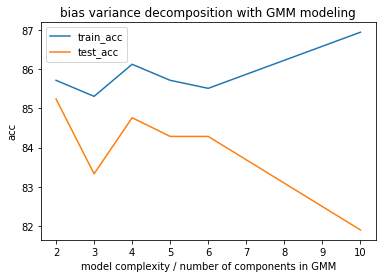

In [18]:
plt.title('bias variance decomposition with GMM modeling')
plt.xlabel('model complexity / number of components in GMM')
plt.ylabel('acc')
plt.plot([2,3,4,5,6,10], train_acc, label='train_acc')
plt.plot([2,3,4,5,6,10], TEST_acc, label='test_acc')
plt.legend()
plt.savefig('BiasVariance_GMM.png',dpi=300)
plt.show()